## An Introduction to NetworkUnit
#### with examples of comparing model implementations (C vs. SpiNNaker) and experimental data (monkey L vs. monkey N)

&nbsp;

*navigate through the slides with the spacebar or arrow keys*

*or view the Jupyter notebook by clicking the X in the upper left corner*

When considering model simulations and their evaluation, it is important
to precisely define the terminology and to be clear about the interpretation
of the results in order to judge the validity and the scope of applicability
of the model. For all practical purposes, in modeling one should be
concerned with its testable correctness relative to the given system
of interest, because only this process justifies its use as the basis
for analytic reasoning and prediction making.

In 1979 the Technical Committee on Model Credibility of the Society
of Computer Simulation established a widely recognized description
of a model verification and validation environment. We adapt this
terminology to the field of neural network modeling 
([*Trensch et al.* , 2018](#trensch2018); [*Gutzen et al.* , sub.](#gutzen2018)). 
The validation setup
is separated into three basic elements (see figure below).
The system of interest can be defined as "an entity, situation,
or system which has been selected for analysis" ([*Schlesinger et al.* ,1979.](#schlesinger1979)),
and constitutes the references against which validations are carried
out. When specifying this system of interest it is important to also
explicitly define the boundaries in which the modeling is expected
to be adequate. The modeling effort itself is separated into the definition
of the conceptual model, and its implementation as a computerized
model. The conceptual model is an abstract description formed by analysis
and observation of the system of interest. In the case of network
simulations, the conceptual model takes on the form of a mathematical
model describing the dynamics of neurons and the connectivity structure,
and other dynamic features of the simulation (e.g., inclusion of neuromodulatory
effects). An implementation of the conceptual mathematical model in
a computer software or in hardware, on the other hand, results in
a computerized, or more concretely for neural simulation, an executable
model.

The process of evaluating the degree to which the executable model is a correct
realization of the mathematical model is termed 'verification'.
In contrast, the comparison of the predictions generated by the computerized
model to the system of interest considering its intended domain of
applicability is the process called 'validation'. Together with
the process of 'confirmation', which attributes credibility to the
mathematical model as a useful description of the system of interest,
these three attributes form a circle that typically receives multiple
iterations consisting of improvements of the mathematical model and
its implementation as an executable model.

<div style='float:left; width:48%; display:inline-block'>
    <img src="../figures/validation_environment.png" width="100%" />
</div>
<div style='float:right; text-align:left; width:48%; display:inline-block'>
    <p><b>System of interest:</b> an entity, situation, or system which has been selected for analysis</p><br>
    <p><b>Mathematical model:</b> an abstract description formed by analysis and observation of the system of interest.</p><br>
    <p><b>Executable model:</b> an implementation of the mathematical model</p><br>
    <p><b>Confirmation:</b> attributing credibility to the mathematical model as a useful description of the system of interest.</p><br>
    <p><b>Verification:</b> evaluation whether the executable model is a correct realization of the mathematical model</p><br>
    <p><b>Validation:</b> a quantitative evaluation of usefulness and accuracy</p><br>
</div>

The NetworkUnit module builds upon the formalized validation scheme of the [SciUnit](https://github.com/scidash/sciunit) package, 
which enables the validation of *model*s against experimental data (or other models) via *tests*.
A test is matched to the model by *capabilities* and quantitatively evaluated by a *score*.
The following figure illustrates a typical test design within NetworkUnit. 
The blue boxes indicate the components of the implementation of the validation test, i.e., 
classes, class instances, data sets, and parameters. 
The relation between the boxes are indicated by annotated arrows.The basic functionality is 
shown by green arrows.  The difference in the test design for comparing against experimental 
data (validation) and  another  simulation  (substantiation)  is  indicated  by  yellow  and  
red  arrows,  respectively.  The  relevant  functionality  of  some  components  for  the  
computation  of  test  score  is  indicated  by  pseudo-code.  The  capability  
class `ProducesProperty` contains  the  function `calc_property()`. The test `XYTest` has a function 
`generate_prediction()` which makes use of this capability, inherited by the model class, 
to generate a model prediction. The initialized test instance `XYTest_paramZ` makes use of its 
`judge()` function to evaluate this model prediction and compute the score `TestScore`. 
The `XYTest` can inherit from multiple abstract test classes (`BaseTest`), 
which is for example used with the `M2MTest` to add the functionality of evaluating multiple model classes. 
To make the test executable it has to be linked to a ScoreType and all free parameters need to be set 
(by a `Params` dict) to ensure a reproducible result.

<div style='width:50%; display:block; margin-left:auto; margin-right:auto'>
        <img src="../figures/NetworkUnit_Flowchart_X2M_M2M.png" width="100%" />
</div>

So far, we considered a scenario in which a model is compared to experimental
observations. However, there are circumstances in which a model is
the object of reference. This model could be another implementation
of the model under scrutiny, an alternative model, or a different
simulation run of the same model. In the following, we explore such
validation scenarios, which we collectively term *model-to-model
validation*. When using NetworkUnit every test comparing model to 
experiment (`example_test`) can be transformed to a test comparing 
two (or more) models by inheritence of the `M2MTest` class.

`class example_test_M2M(sciunit.TestM2M, example_test):`

One possible scenario is the need to demonstrate the
equivalence of alternative implementations of the same model. These
implementations could, for example, be realized by different simulation
engines, like in our first example by a C simulation and a simulation on the SpiNNaker hardware.

In [1]:
%matplotlib inline
import sys
import sciunit
import numpy as np
import neo
sys.path.insert(0, '../')
from networkunit import models, tests, scores, plots, capabilities
from copy import copy  
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks')
import warnings
warnings.filterwarnings('ignore')

### Validating a SpiNNaker simulation against a C simulation
For this comparison we use a polychronization network model ([*Izhikevich* , 2006](#izhikevich2006)) as it produces a rich repertoir of network dynamics. This model simulated with both a C implementation and an implementation on the neuromorphic SpiNNaker system.

The simulation data is available via [a GIN repository](https://web.gin.g-node.org/INM-6/network_validation) from which it can be loaded into the local storage with *git-annex* (or alternatively the gin-client).

In [2]:
# Clone gin repository 
!git clone git@gin.g-node.org:/INM-6/network_validation.git

# load simulation data
os.chdir('./network_validation')
!git-annex get ./simulation_data/iteration_III/60s_simulation_runs/*/out_firings_after5h.dat
os.chdir('..')
data_path = "./network_validation/simulation_data/iteration_III/60s_simulation_runs/"

fatal: destination path 'network_validation' already exists and is not an empty directory.


On a remote server it is only possible to download the data with `wget`.

#### The simulation is implemented in a model class
The model class should either be able to run the simulation or else load data from a simulation (what we do here).

In [3]:
class polychrony_data(models.spiketrain_data):
    file_path = '' # to be added in child class
    params = {'align_to_0': True,
              'filter_inh': True}
    
    def load(self, file_path, simulator, t_start=0, t_stop=60000, filter_inh=False, **kwargs):
        f = open(file_path, 'r')
        lines = f.readlines()
        
        N = 1000 # neurons 
        
        # Read Spike Times
        spike_times = [[]] * N
        for line in lines:
            sec, msec, n = line.split(' ')[:3]
            t = float(sec)*1000. + float(msec)
            n = int(n)
            if t > t_stop:
                break
            spike_times[n] = spike_times[n] + [t]

        # Fill Spike Trains
        nbr_neurons = N
        if filter_inh:
            nbr_neurons = 800
            
        spiketrains = [[]] * nbr_neurons
        for n, st in enumerate(spike_times):
            if n < 800:
                n_type = 'exc'
            else:
                n_type = 'inh'
            if not filter_inh or n_type == 'exc':
                spiketrains[n] = neo.core.SpikeTrain(np.sort(st), units='ms', 
                                                     t_start=t_start, t_stop=t_stop,
                                                     n_type=n_type, unitID=n)
        return spiketrains

#### For the model-to-model comparison we derive a model class for each implementation

In [4]:
# C simulation
class C_sim(polychrony_data):
    file_path = data_path + 'C/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#2173a3', simulator='C')
    
# SpiNNaker simulation    
class S_sim(polychrony_data):
    file_path = data_path + 'SpiNNaker/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#77b74a', simulator='SpiNNaker')

In [5]:
C = C_sim(name='C')
S = S_sim(name='SpiNNaker')

#### Show the spiking activity data

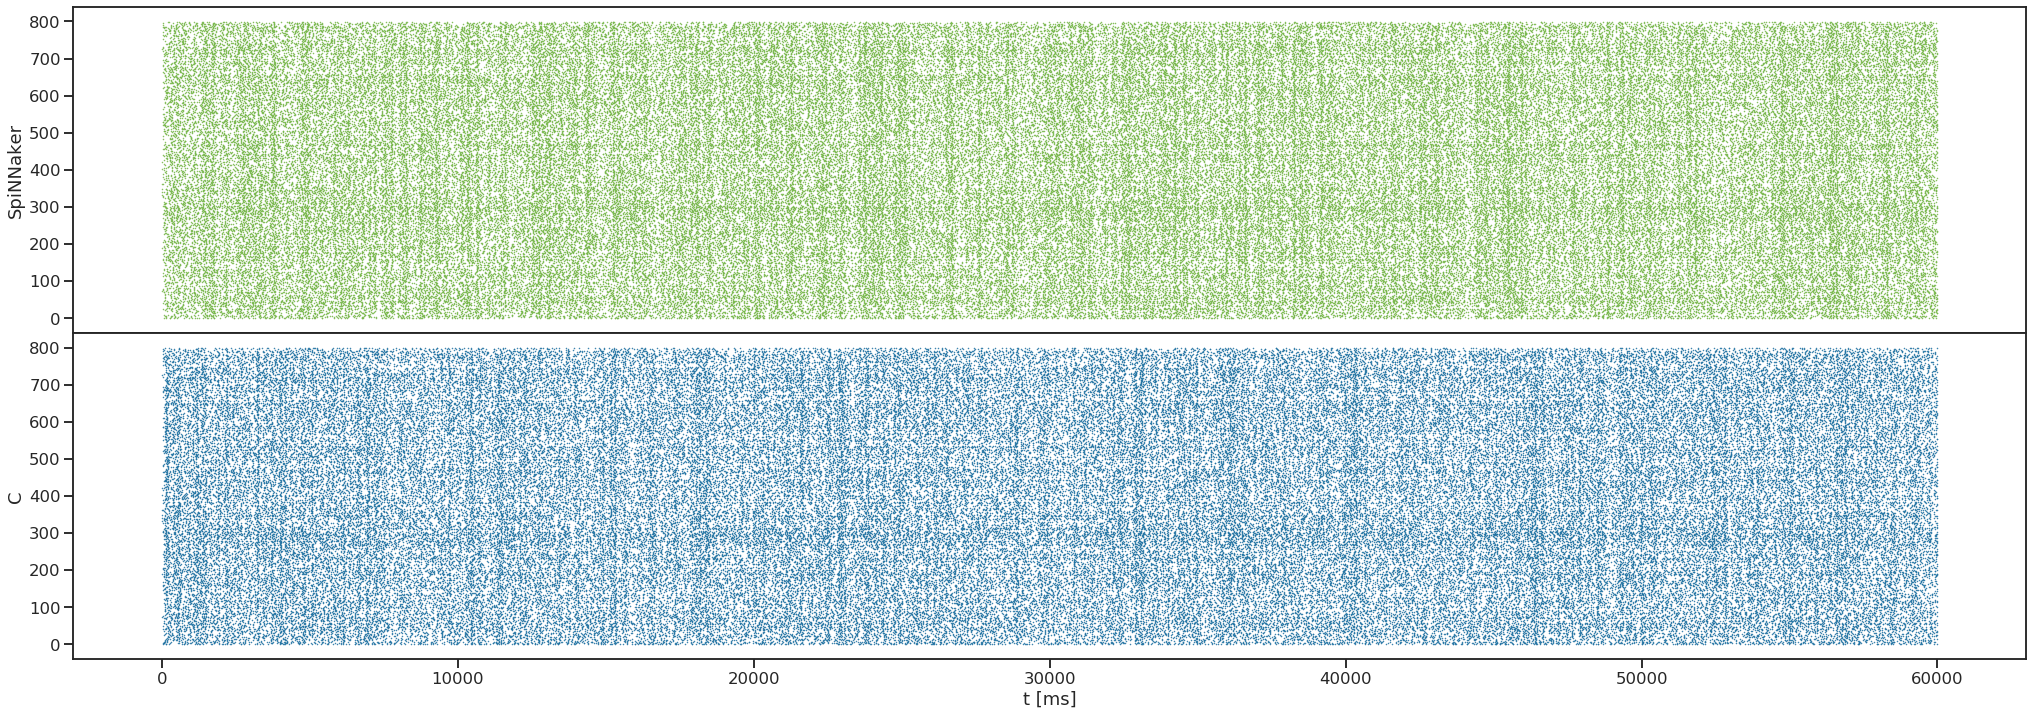

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True, 
                       gridspec_kw={'hspace':0}, 
                       figsize=(35,12))

for sim_count, sim in enumerate([S, C]):
    sim.produce_spiketrains()
    for st_count, st in enumerate(sim.spiketrains):
        ax[sim_count].plot(st, [st_count]*len(st), 
                           color=sim.params['color'], 
                           marker='.', markersize=1.,
                           linestyle="None")
        
    ax[sim_count].set_ylabel(sim.name)
ax[-1].set_xlabel('t [ms]');

#### Test definitons
The validation tests are also defined as classes. NetworkUnit offers a variety of base tests from which tests can be derived.

In [7]:
class FR_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.effect_size
    
class LV_test_class(sciunit.TestM2M, tests.isi_variation_test):
    score_type = scores.effect_size
    params = {'variation_measure': 'lv'}
    
FR_test = FR_test_class()
LV_test = LV_test_class()

#### What can tests do?
... every test has a function generate_prediction() which calculates the test measure

In [8]:
FR_test.generate_prediction(C);

#### What can tests do?
... the test classes are also able to visualize the the generated samples.

No handles with labels found to put in legend.


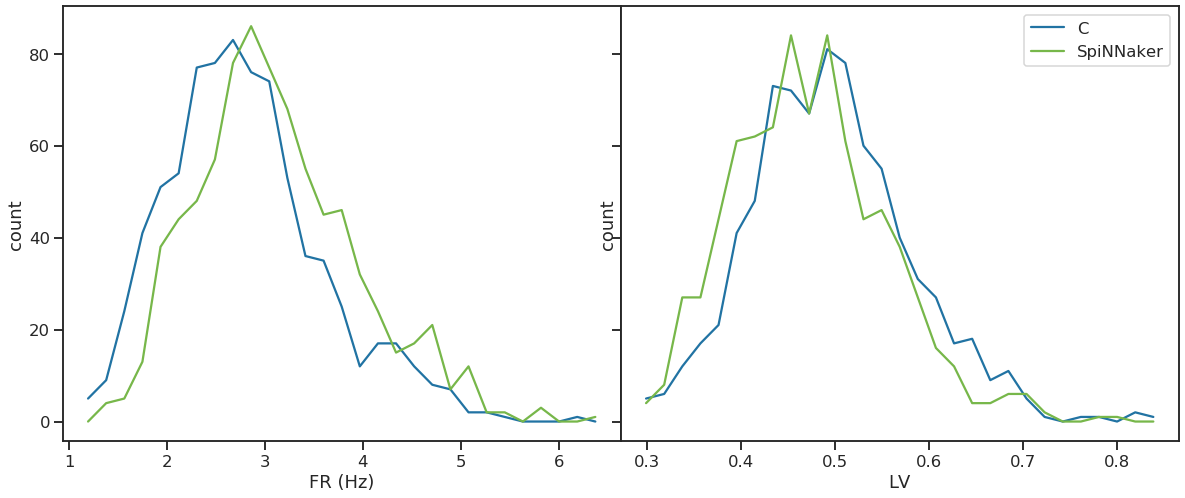

In [9]:
fig, ax = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0}, figsize=(20,8))

FR_test.visualize_samples(C, S, ax=ax[0], var_name='FR (Hz)', bins=30, density=False)
LV_test.visualize_samples(C, S, ax=ax[1], var_name='LV', bins=30, density=False);

#### What can tests do? 
... to perform the actual validation and calculate a test score, you call the judge() function, which will
    1. check if the model has all the required capabilities.
    2. call generate_prediction()
    3. call compute_score()
    4. check that the score is of score_type
    5. equip the score with metadata
    6. returns the score.

In [10]:
# For a model-to-model test the two models are passed as a list
print('FR test:\n', FR_test.judge([C, S]).score)

FR test:
                   C  SpiNNaker
C          0.000000   0.394106
SpiNNaker  0.394106   0.000000


In [11]:
# to access an element of the score DataFrame use
print('FR-Test ', FR_test.judge([C, S]).iloc[1,0])
print('LV-Test ', LV_test.judge([C, S]).iloc[1,0])
# print of a score instance invokes the __str__ property of the test

FR-Test  

Effect Size
	datasize: 800 	 800
	Effect Size = 0.394 	 CI = (0.295, 0.493)


LV-Test  

Effect Size
	datasize: 800 	 800
	Effect Size = 0.271 	 CI = (0.172, 0.369)




#### Using a different statistical test as score type is as simple as

In [12]:
class FR_ks_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.ks_distance # students_t, kl_divergence, mwu_statistic, best_effect_size, LeveneScore

FR_ks_test = FR_ks_test_class()

print(FR_ks_test.judge([C, S]).iloc[1,0])



Kolmogorov-Smirnov-Distance
	datasize: 800 	 800
	D_KS = 0.185 	 p value = 2.23e-12




### That's all good and fine but what about experimental data !?!?!?

The experimental data for this example is taken from [Brochier et al. (2018)](brochier2018). The provided datasets were recorded in the motor cortex of two macaque monkeys using Utah multi-electrode arrays. The underlying task was an instructed delayed reach-to-grasp task, the details of which are described in [Riehle et al. (2013)](#riehle2013) and [Brochier et al. (2018)](brochier2018).

#### load the data and utility functions (local)

In [13]:
# Clone repository (this will not download large data files)
!git clone git@gin.g-node.org:/doi/multielectrode_grasp.git

# download large data files needed for this example
os.chdir('./multielectrode_grasp')
!git-annex get ./datasets/l101210-001.odml # metadata for monkey L
!git-annex get ./datasets/l101210-001.ns2 # analog signals for monkey L
!git-annex get ./datasets/l101210-001.ccf
!git-annex get ./datasets/l101210-001.nev # unsorted spike times for monkey L
!git-annex get ./datasets/l101210-001-02.nev # sorted spike times for monkey L
!git-annex get ./datasets/i140703-001.odml # metadata for monkey I
!git-annex get ./datasets/i140703-001.ns2 # analog signals monkey I
!git-annex get ./datasets/i140703-001.ccf
!git-annex get ./datasets/i140703-001.nev # unsorted spike times for monkey I
!git-annex get ./datasets/i140703-001-03.nev # sorted spike times for monkey I
os.chdir('..')

# set data path
download_path = "./multielectrode_grasp/"
data_path = './multielectrode_grasp/datasets/'

Cloning into 'multielectrode_grasp'...
remote: Enumerating objects: 4061, done.
remote: Counting objects: 100% (4061/4061), done.
remote: Compressing objects: 100% (2796/2796), done.
remote: Total 4061 (delta 1097), reused 1927 (delta 228)
Receiving objects: 100% (4061/4061), 3.86 MiB | 4.18 MiB/s, done.
Resolving deltas: 100% (1097/1097), done.
(merging origin/git-annex origin/synced/git-annex into git-annex...)
(recording state in git...)
get datasets/l101210-001.odml (from origin...) 
MD5-s2782094--eac81b0562c9cfff8ddda263095990b1
      2,782,094 100%    3.87MB/s    0:00:00 (xfr#1, to-chk=0/1)
(checksum...) ok
(recording state in git...)
get datasets/l101210-001.ns2 (from origin...) 
MD5-s8511032--66d7cca0ec1479056b561fa85c6d222b
      8,511,032 100%    4.74MB/s    0:00:01 (xfr#1, to-chk=0/1)
(checksum...) ok
(recording state in git...)
get datasets/l101210-001.ccf (from origin...) 
MD5-s108204--dd2be8e8417f21a1e61da5e90e65f386
        108,204 100%    5.43MB/s    0:00:00 (xfr#1, to-

#### load the data and utility functions (on server)

In [14]:
!( echo "code/reachgraspio/reachgraspio.py" \
&& echo "code/neo_utils.py" \
&& echo "datasets/l101210-001.odml" \
&& echo "datasets/l101210-001.ns2" \
&& echo "datasets/l101210-001.nev" \
&& echo "datasets/l101210-001-02.nev" \
&& echo "datasets/i140703-001.odml" \
&& echo "datasets/i140703-001.ns2" \
&& echo "datasets/i140703-001.ccf" \
&& echo "datasets/i140703-001.nev" \
&& echo "datasets/i140703-001-03.nev") \
> download_files.txt
!wget -nH -nc -r -np -e robots=off -i download_files.txt -B https://web.gin.g-node.org/doi/multielectrode_grasp/raw/master/
download_path = "./doi/multielectrode_grasp/raw/master/"
data_path = download_path + 'datasets/'

--2019-07-24 14:43:56--  https://web.gin.g-node.org/doi/multielectrode_grasp/raw/master/code/reachgraspio/reachgraspio.py
Resolving web.gin.g-node.org (web.gin.g-node.org)... 141.84.41.219
Connecting to web.gin.g-node.org (web.gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gin.g-node.org/doi/multielectrode_grasp/raw/master/code/reachgraspio/reachgraspio.py [following]
--2019-07-24 14:43:56--  https://gin.g-node.org/doi/multielectrode_grasp/raw/master/code/reachgraspio/reachgraspio.py
Resolving gin.g-node.org (gin.g-node.org)... 141.84.41.219
Connecting to gin.g-node.org (gin.g-node.org)|141.84.41.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘doi/multielectrode_grasp/raw/master/code/reachgraspio/reachgraspio.py’

doi/multielectrode_     [ <=>                ]  73,83K   485KB/s    in 0,2s    

2019-07-24 14:43:57 (485 KB/s) - ‘doi/multiele

#### Add utility code to the python path

In [15]:
sys.path.insert(0, download_path + 'code')
sys.path.insert(0, download_path + 'code/reachgraspio')
from neo_utils import add_epoch, cut_segment_by_epoch, get_events
import reachgraspio as rgio

ModuleNotFoundError: No module named 'odml'

#### Define model classes as wrappers for the experimental data

In [ ]:
class exp_data(models.experimental_data, capabilities.ProducesSpikeTrains):
    """
    A model class to load data from reach2grasp experiment. Spike times from the
    complete recording sessions are loaded.
    """

    def load(self, datfile, **kwargs):
        """
        Loads data from datfile.
        """        
        # set paths
        fpath = data_path + datfile
        print('loading data from ' + fpath +'.nev')
        print('this may take a minute..')
        # load session and get event times
        session = rgio.ReachGraspIO(fpath, odml_directory=data_path)
        block = session.read_block(nsx_to_load='all', units='all', load_events=True, scaling='voltage')
        data_segment = block.segments[0]
        start_event = get_events(data_segment, properties={
                'trial_event_labels': self.params['start_trigger'],
                'performance_in_trial': session.performance_codes['correct_trial']})[0]
        stop_event = get_events(data_segment, properties={
                'trial_event_labels': self.params['stop_trigger'],
                'performance_in_trial': session.performance_codes['correct_trial']})[0]
        # select segments and get spiketrains
        selected_trial_segments = self.select_trial_segments(data_segment, start_event, stop_event)
        spiketrains = self.get_spiketrains(selected_trial_segments)
        
        return spiketrains
    
    
    def select_trial_segments(self, data_segment, start_event, stop_event, **kwargs):
        '''
        Filters out trials from given data_segment
        ''' 
        epoch = add_epoch(data_segment, event1=start_event, event2=stop_event, attach_result=False)        
        cut_trial_block = neo.Block(name="Cut_Trials")
        cut_trial_block.segments = cut_segment_by_epoch(data_segment, epoch, reset_time=True)
        selected_trial_segments = []
        for tr_typ in self.params['trial_types']:
            selected_trial_segments.extend(cut_trial_block.filter(targdict={'belongs_to_trialtype': tr_typ}, 
                                                                  objects=neo.Segment))
        self.n_trials = len(selected_trial_segments)
        self.n_units = len(selected_trial_segments[0].filter({'sua': True}))
        return selected_trial_segments
        
        
    def get_spiketrains(self, selected_trial_segments, **kwargs):
        '''
        Appends all spike trains in selected_trial_segments to a list
        of spike trains. Spike trains with SNR<2.5 are sorted out.
        '''
        spiketrains = []
        for seg_id, seg in enumerate(selected_trial_segments):
            # Discarding non-valid trials
            if seg.annotations['trial_id'] == -1:
                continue
            # Selecting only the SUAs
            for st in seg.filter({'sua': True}):
                # Check the SNR, only use units with SNR>2.5 (see Brochier et al, 2018)
                if st.annotations['SNR'] > 2.5:
                    st.annotations['trial_id'] = seg.annotations['trial_id']
                    st.annotations['trial_type'] = seg.annotations['belongs_to_trialtype']
                    st.annotate(trial_id_trialtype=seg_id)
                    spiketrains.append(st)
        return spiketrains

#### Define derived model classes for each monkey

TS_ON : trial start

CUE-ON : grip type signal (800ms after TS_ON)

PG / SG : precision grip / side grip

LF / HF : low force / high force

spike trains with SNR < 2.5 are discarded

A general experimental data class is defined, which is the basis to load the two data sets into the NetworkUnit framework. For the sake of simplicity, we load all the single unit activity data within a fixed time window of 800ms ranging from 'TS_ON' to 'CUE_ON'. 'TS_ON' defines the start of the trial and 800ms later the grip type is signalled by 'CUE_ON'. This means that there is no trial type information in the given time window. The data is handed over to NetworkUnit as a list of spiketrains with n_units * n_trial elements. Spike trains are discarded if their signal to noise ration is small (SNR<2.5).

In [ ]:
# Monkey L
class exp_class_L(exp_data):
    datfile = 'l101210-001'
    params = {'start_trigger': 'TS-ON',
              'stop_trigger': 'CUE-ON',
              'trial_types': ['PGLF', 'PGHF', 'SGLF', 'SGHF'],
              'color': '#ff8000'
              }
    
# Monkey I
class exp_class_I(exp_data):
    datfile = 'i140703-001'
    params = {'start_trigger': 'TS-ON',
              'stop_trigger': 'CUE-ON',
              'trial_types': ['PGLF', 'PGHF', 'SGLF', 'SGHF'],
              'color': '#9b59b6'
              }

In [ ]:
L = exp_class_L(name='Monkey L')
I = exp_class_I(name='Monkey I')

#### Show spiking activity data

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True, 
                       gridspec_kw={'hspace':0}, 
                       figsize=(35,12))

for exp_count, exp in enumerate([L, I]):
    exp.produce_spiketrains()
    for st_count, st in enumerate(exp.spiketrains):
        ax[exp_count].plot(st, [st_count]*len(st), 
                           color=exp.params['color'],
                           marker='.', markersize=1.,
                           linestyle="None")
        
    ax[exp_count].set_ylabel(exp.name)
ax[-1].set_xlabel('t [ms]');

### We use the same tests as before to compare the data sets

In [ ]:
fig, ax = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0}, figsize=(20,8))

FR_test.visualize_samples(L, I, ax=ax[0], var_name='FR (Hz)', bins=30, density=False)
LV_test.visualize_samples(L, I, ax=ax[1], var_name='LV', bins=30, density=False);

In [ ]:
print('FR-Test ', FR_test.judge([C, S]).iloc[1,0])
print('LV-Test ', LV_test.judge([C, S]).iloc[1,0])

### Conclusion

#### Validation testing on the level of network activity is a useful apprach (complementary to single-cell validation) to evaluate network models

#### NetworkUnit can be used to quantify the statistical difference between models and experimental data sets

#### Validation testing is applicable for 
- a) comparing model predictions to experimental findings, 
- b) guiding the model development, 
- c) checking for consistency within or across models (or data sets).

<p><i>"A model, like a novel, may resonate with nature, but it is not a 'real' thing. Like novel, a model may be convinving - it may 'ring true' if it is consistent with our experience of the natural world. But just as we may wonder how much the characters in a novel are drawn from real life and how much is artifice, we might ask the same of a model: How much is based on observation and measurement of accesssible phenomena, how much is based on informed judgment, and how much is convencience?"</i></p>
<p style="float:right">Orsekes, 1994</p>


### References

- Trensch et al. (2018)  Rigorous neural network simulations: model cross-validation665for boosting the correctness of simulation results, Frontiers in Neuroinformatics 12:81, doi: 10.3389/fninf.2018.00081 <a id='trensch2018'></a>

- Gutzen et al. (2018) Reproducible neural network simulations: model validation on the level of network activity data, Frontiers in Neuroinformatics 12:90, doi: 10.3389/fninf.2018.00090 <a id='gutzen2018'></a>

- Schlesinger, S. (1979). Terminology for model credibility, Simulation 32, 103-104. doi: 10.1177/003754977903200304<a id='schlesinger1979'></a> 

- Izhikevich, E. M. (2006). Polychronization: Computation with spikes, Neural Computation 18, 245–282. doi: 10.1162/089976606775093882 <a id='izhikevich2006'></a> 

- Brochier et al. (2018) Massively parallel recordings in macaque motor cortex during an instructed delayed reach-to-grasp task, Scientific Data, 5, pp. 1–23. doi: 10.1038/sdata.2018.55. <a id='brochier2018'></a> 

- Riehle et al. (2013) Mapping the spatio-temporal structure of motor cortical LFP and spiking activities during reach-to-grasp movements, Frontiers in Neural Circuits, 7(48). doi: 10.3389/fncir.2013.00048. <a id='riehle2013'></a> 

